Epoch 1/5 Training:  80%|███████▉  | 960/1201 [2:11:25<32:40,  8.14s/it]  c:\Users\Aman\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/5  Loss: 0.5507  Train Acc: 0.8065  Val Acc: 0.8315


Epoch 2/5  Loss: 0.4135  Train Acc: 0.8582  Val Acc: 0.8137


Epoch 3/5  Loss: 0.3306  Train Acc: 0.8888  Val Acc: 0.8430


Epoch 4/5  Loss: 0.2770  Train Acc: 0.9081  Val Acc: 0.8353


Epoch 5/5  Loss: 0.2354  Train Acc: 0.9213  Val Acc: 0.8404


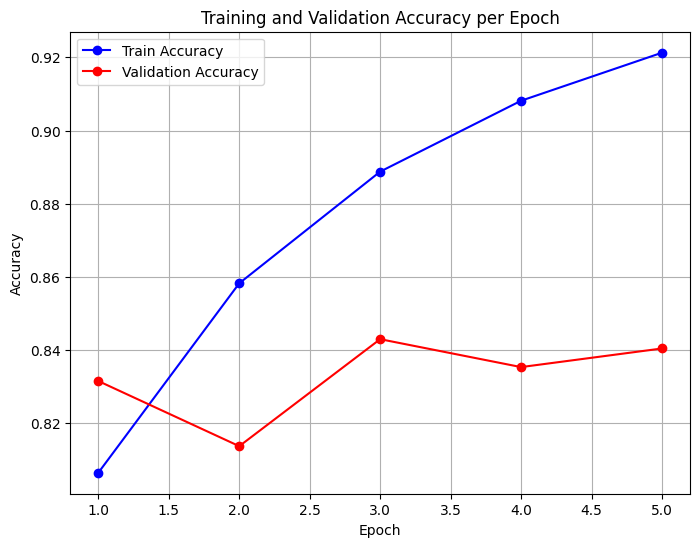

Extracting features for TSNE: 100%|██████████| 197/197 [08:36<00:00,  2.62s/it]


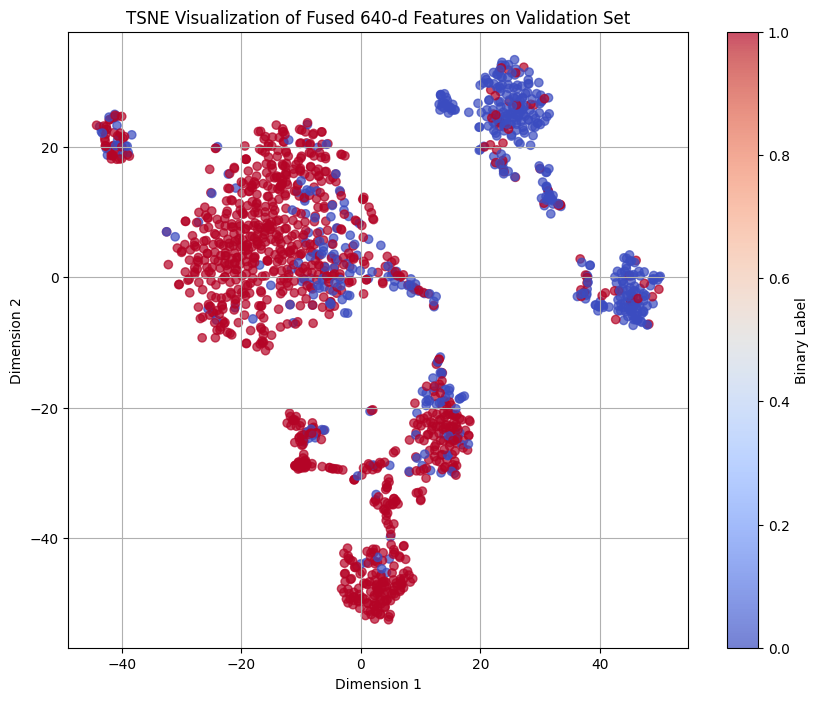

In [3]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from transformers import AutoProcessor, AutoModel
from tqdm import tqdm  # For progress bars
from sklearn.manifold import TSNE  # For TSNE visualization

# --- Load & Filter Data ---
train_data = pd.read_csv(
    'crisismmd_datasplit_all/crisismmd_datasplit_all/task_informative_text_img_train.tsv',
    sep='\t'
)
dev_data = pd.read_csv(
    'crisismmd_datasplit_all/crisismmd_datasplit_all/task_informative_text_img_dev.tsv',
    sep='\t'
)

train_data = train_data[train_data['label_text_image'] == 'Positive'].reset_index(drop=True)
dev_data   = dev_data[dev_data['label_text_image'] == 'Positive'].reset_index(drop=True)
label_map = {"informative": 1, "not_informative": 0}
train_data['binary_label'] = train_data['label'].map(label_map)
dev_data['binary_label']   = dev_data['label'].map(label_map)

# --- Custom Dataset ---
class CrisisDataset(Dataset):
    def __init__(self, dataframe, processor):
        self.data = dataframe
        self.processor = processor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        tweet_text = row['tweet_text']
        image_path = row['image']
        label = int(row['binary_label'])
        
        if not os.path.exists(image_path):
            raise FileNotFoundError(f"Image file {image_path} not found.")
        image = Image.open(image_path).convert("RGB")
        
        inputs = self.processor(
            text=tweet_text,
            images=image,
            return_tensors="pt",
            padding="max_length",
            truncation=True
        )
        # Remove extra batch dimension and add label.
        inputs = {key: tensor.squeeze(0) for key, tensor in inputs.items()}
        inputs['labels'] = torch.tensor(label, dtype=torch.float)
        return inputs

# --- Load Processor & Base Model ---
processor = AutoProcessor.from_pretrained("kakaobrain/align-base")
base_model = AutoModel.from_pretrained("kakaobrain/align-base")
hidden_size = 640  # As defined for the base model's hidden size

# --- Build Classification Model with Late Fusion ---
class AlignForBinaryClassification(nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.base_model = base_model
        # Directly classify the fused raw embeddings (averaged).
        self.classifier = nn.Linear(hidden_size, 1)
    
    def forward(self, input_ids, attention_mask, pixel_values):
        outputs = self.base_model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            pixel_values=pixel_values,
            return_dict=True
        )
        # Directly fuse the raw text and image embeddings by averaging.
        fused = (outputs.text_embeds + outputs.image_embeds) / 2.0
        logits = self.classifier(fused)
        return logits
    
    def extract_features(self, input_ids, attention_mask, pixel_values):
        """
        Extracts the fused 640-d representation (used for TSNE visualization).
        """
        outputs = self.base_model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            pixel_values=pixel_values,
            return_dict=True
        )
        fused = (outputs.text_embeds + outputs.image_embeds) / 2.0
        return fused

# --- Prepare DataLoaders ---
train_dataset = CrisisDataset(train_data, processor)
val_dataset   = CrisisDataset(dev_data, processor)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=8, shuffle=False)

# --- Training Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AlignForBinaryClassification(base_model).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=2e-5)

# --- Training Loop ---
num_epochs = 5
train_acc_history = []
val_acc_history = []

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    # Training loop with progress bar.
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} Training", leave=False):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        pixel_values = batch['pixel_values'].to(device)
        labels = batch['labels'].to(device).unsqueeze(1)
        
        optimizer.zero_grad()
        logits = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            pixel_values=pixel_values
        )
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * input_ids.size(0)
        preds = (torch.sigmoid(logits) > 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    
    train_acc = correct / total
    train_acc_history.append(train_acc)
    avg_loss = running_loss / total

    model.eval()
    val_correct, val_total = 0, 0
    # Validation loop with progress bar.
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} Validation", leave=False):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            pixel_values = batch['pixel_values'].to(device)
            labels = batch['labels'].to(device).unsqueeze(1)
            logits = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                pixel_values=pixel_values
            )
            preds = (torch.sigmoid(logits) > 0.5).float()
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
    
    val_acc = val_correct / val_total
    val_acc_history.append(val_acc)
    
    print(f"Epoch {epoch+1}/{num_epochs}  Loss: {avg_loss:.4f}  Train Acc: {train_acc:.4f}  Val Acc: {val_acc:.4f}")

# --- Plot Accuracy per Epoch ---
epochs_range = range(1, num_epochs + 1)
plt.figure(figsize=(8, 6))
plt.plot(epochs_range, train_acc_history, 'bo-', label='Train Accuracy')
plt.plot(epochs_range, val_acc_history, 'ro-', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy per Epoch')
plt.legend()
plt.grid(True)
plt.show()

# --- TSNE Visualization of Fused Features ---
# Extract features from the validation set using the model's extract_features() method.
all_features = []
all_labels = []
model.eval()
with torch.no_grad():
    for batch in tqdm(val_loader, desc="Extracting features for TSNE"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        pixel_values = batch['pixel_values'].to(device)
        labels = batch['labels'].to(device)
        features = model.extract_features(input_ids, attention_mask, pixel_values)
        all_features.append(features.cpu())
        all_labels.append(labels.cpu())

# Concatenate all features and labels.
all_features = torch.cat(all_features, dim=0)
all_labels = torch.cat(all_labels, dim=0)

# Apply TSNE to reduce the fused 640-d features to 2D for visualization.
tsne = TSNE(n_components=2, random_state=42)
features_2d = tsne.fit_transform(all_features.numpy())

# Plot TSNE results.
plt.figure(figsize=(10, 8))
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=all_labels.numpy(), cmap='coolwarm', alpha=0.7)
plt.colorbar(scatter, label='Binary Label')
plt.title("TSNE Visualization of Fused 640-d Features on Validation Set")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.grid(True)
plt.show()
